## `genalog.degradation` module:

This module is responsible for:
- Apply degradation effects to mimic analog documents

These effects include:
1. **Blurring**: typical blurring effect
1. **Bleed-through**: the see-through effect of material printed on the other side of the double-sided document
1. **Ink degradation**: natural degradation of the printed medium. We will use a combination of the following image manipulations:
   1. **Salt and pepper noise**: we can randomly sprinkle "salt" (white pixels) and "pepper" (dark pixels) onto the original image to imitate ink degradation and page degradation
   2. [**Morphological operations**](http://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm): we will primarily use the "open" and "close" operations

Note that many of the standard [morphological operations](http://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm) are binary image operations, so we are only supporting  **single channel** grayscale image, not RGB channels. All image must be converted to its single channel grayscale representation before apply degradation affects. More specifically, the source image should be of shape (rows, cols), and each pixel is of type `numpy.uint8` to ensure maximum capatiability with different `cv2` methods.

In [28]:
import cv2
import numpy as np
import genalog.degradation.effect as effect
from matplotlib import pyplot as plt

# Configure plot sizes
# plt.rcParams['xtick.labelsize'] = 5
# plt.rcParams['ytick.labelsize'] = 5
%matplotlib inline

(797, 1160) uint8


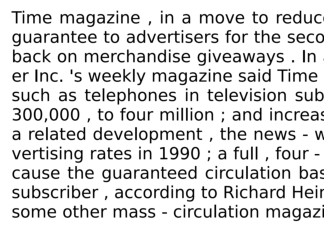

In [29]:
# Load in sample image
src = cv2.imread('sample/degradation/text_zoomed.png', cv2.IMREAD_GRAYSCALE)

# Note that the image is has ONE channel, and has `uint8` integer type with range [0,255]
print(src.shape, src.dtype)
plt.axis('off')
plt.imshow(src, cmap="gray")

## Degrader Class

The `Degrader` Class can apply multiple degradations on the same image. We will explain each individual degradation effect in the following sections.

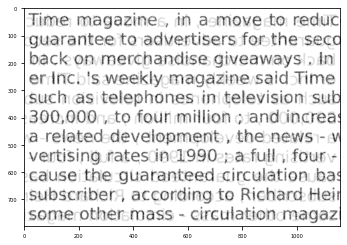

In [30]:
from genalog.degradation.degrader import Degrader

# We are applying degradation effects to the images in the following sequence:
# blur -> bleed_through -> salt
degradations = [
    ("blur", {"radius": 3}),
    ("bleed_through", {"alpha": 0.8}),
    ("salt", {"amount": 0.2}),
]
# All of the referenced degradation effects are in submodule `genalog.degradation.effect`

degrader = Degrader(degradations)
dst = degrader.apply_effects(src)

plt.imshow(dst, cmap="gray")

### Advance Degradation Configurations

`genalog` provides an enumeration class `ImageState` to reference the image at different state in the degradation process. For example, 
1. `ImageState.ORIGINAL_STATE` refers to the origin state of the image before applying any degradation, while 
1. `ImageState.CURRENT_STATE` refers to the state of the image after applying the last degradation effect. 

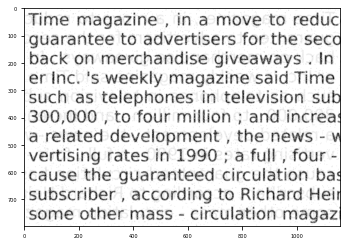

In [31]:
from genalog.degradation.degrader import Degrader, ImageState

degradations = [
    ("morphology", {"operation": "open", "kernel_shape":(9,9), "kernel_type":"plus"}),
    ("morphology", {"operation": "close", "kernel_shape":(9,1), "kernel_type":"ones"}),
    ("salt", {"amount": 0.7}),
    ("overlay", {
        "src": ImageState.ORIGINAL_STATE,
        "background": ImageState.CURRENT_STATE,
    }),
    ("bleed_through", {
        "src": ImageState.CURRENT_STATE,
        "background": ImageState.ORIGINAL_STATE,
        "alpha": 0.90,
        "offset_x": -5,
        "offset_y": -5,
    }),
    ("pepper", {"amount": 0.005}),
    ("blur", {"radius": 3}),
    ("salt", {"amount": 0.15}),
]

degrader = Degrader(degradations)
dst = degrader.apply_effects(src)
plt.imshow(dst, cmap="gray")

## Individual Degradation Effect

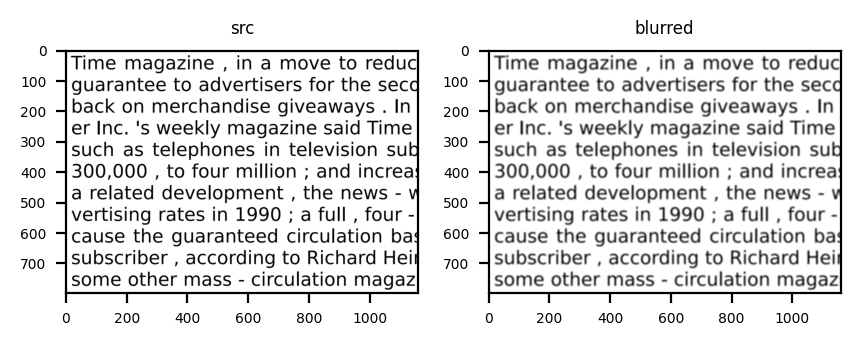

In [32]:
blurred = effect.blur(src, radius=7) # the larger the radius, the lower the contrast

# display input and output image
fig = plt.figure(figsize=(5, 4), dpi=200)
fig.add_subplot(1,2,1)
plt.imshow(src, cmap="gray")
plt.title('src', fontsize=6)
fig.add_subplot(1,2,2)
plt.imshow(blurred, cmap="gray")
plt.title('blurred', fontsize=6)
plt.show()

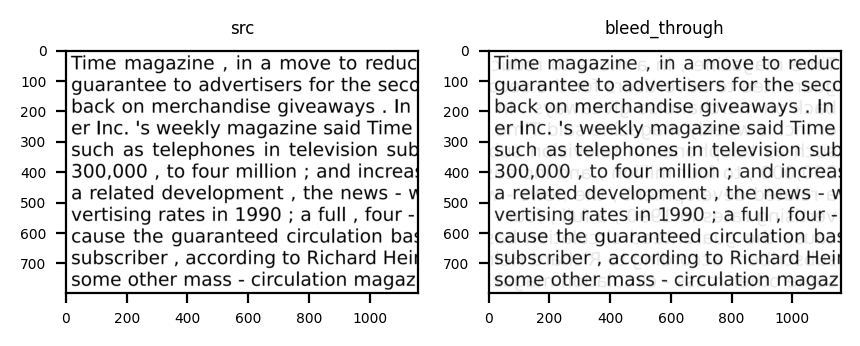

In [8]:
# alpha is the transparancy factor for the foreground, and 1-alpha for the background
# by default, the background is the same source image flipped horizontally
bleed_through = effect.bleed_through(src, alpha=0.9)# higher the alpha, the less visible is the effect

# display input and output image
fig = plt.figure(figsize=(5, 4), dpi=200)
fig.add_subplot(1,2,1)
plt.imshow(src, cmap="gray")
plt.title('src', fontsize=6)
fig.add_subplot(1,2,2)
plt.imshow(bleed_through, cmap="gray")
plt.title('bleed_through', fontsize=6)
plt.show()

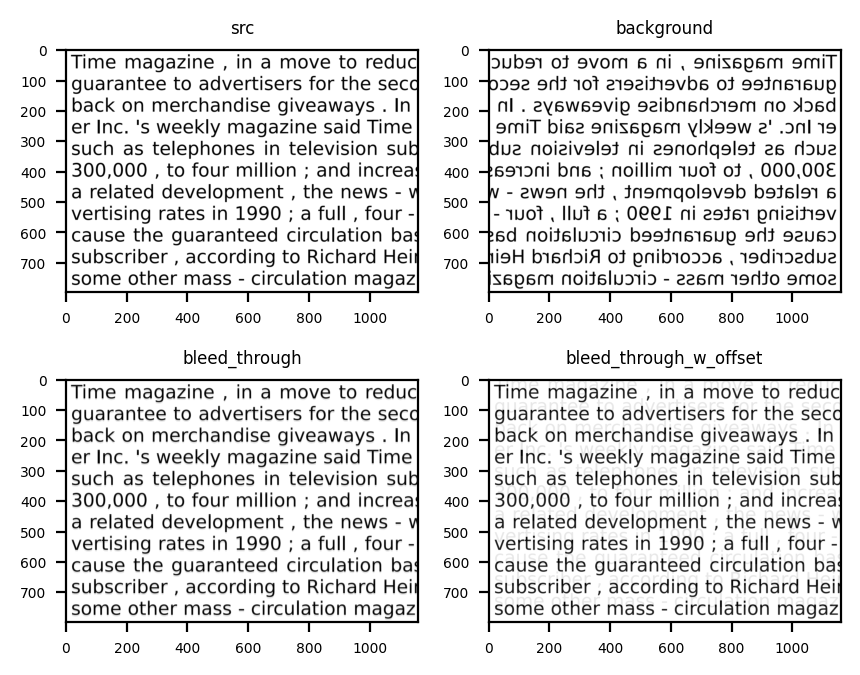

In [9]:
# Bleed-through with custom background
background = cv2.flip(src, 1)

# alpha is the transparancy factor for the foreground, and 1-alpha for the background
bleed_through = effect.bleed_through(src, background=background, alpha=0.9)# higher the alpha, the less visible is the effect
# shift background up by 25px
bleed_through_w_offset = effect.bleed_through(src, background=background, alpha=0.9, offset_x=0, offset_y=-25) 

# display input and output image
fig = plt.figure(figsize=(5, 4), dpi=200)
fig.add_subplot(2,2,1)
plt.imshow(src, cmap="gray")
plt.title('src', fontsize=6)
fig.add_subplot(2,2,2)
plt.imshow(background, cmap="gray")
plt.title('background', fontsize=6)
fig.add_subplot(2,2,3)
plt.imshow(bleed_through, cmap="gray")
plt.title('bleed_through', fontsize=6)
fig.add_subplot(2,2,4)
plt.imshow(bleed_through_w_offset, cmap="gray")
plt.title('bleed_through_w_offset', fontsize=6)
plt.show()

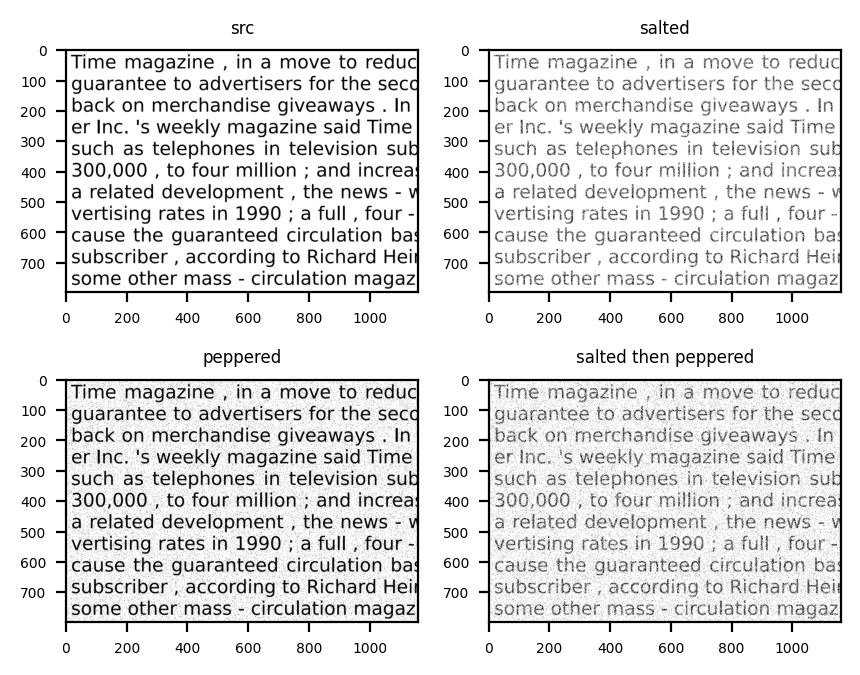

In [10]:
from skimage.util.noise import random_noise
salted = effect.salt(src, amount=0.4) # amount is the percentage of pixels to be salted (whitened)
peppered = effect.pepper(src, amount=0.05) # amount is the percentage of pixels to be peppered (darkened)
salt_then_pepper = effect.salt_then_pepper(src, 0.4, 0.05)

# display input and output image
fig = plt.figure(figsize=(5,4), dpi=200)
fig.add_subplot(2,2,1)
plt.imshow(src, cmap="gray")
plt.title('src', fontsize=6)
fig.add_subplot(2,2,2)
plt.imshow(salted, cmap="gray")
plt.title('salted', fontsize=6)
fig.add_subplot(2,2,3)
plt.imshow(peppered, cmap="gray")
plt.title('peppered', fontsize=6)
fig.add_subplot(2,2,4)
plt.imshow(salt_then_pepper, cmap="gray")
plt.title('salted then peppered', fontsize=6)
plt.show()

## Morphological Operations:

`erode` and `dilate` are the primary operations. `open` and `close` are their less destructive counterparts. The convention is that these operations will be applied to a binary image with its foreground in white and background in black. However, our text images have the **opposite** polarity, where the foreground (text characters) is black and the background (the page) is white. Thus, to "**erode**" away the characters on page, will will have to apply the `dilate` method and vice versa.


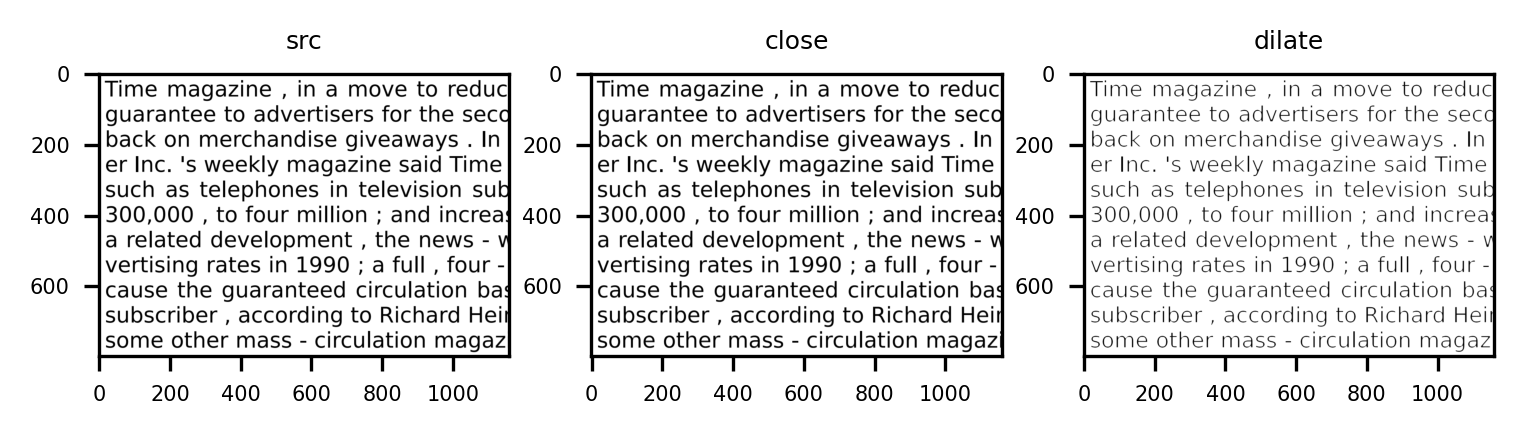

In [11]:
kernel = effect.create_2D_kernel((3,3), kernel_type="ones")
dilate = effect.dilate(src, kernel)
close = effect.close(src, kernel)# less destructive than dilation, given the same kernel

# display input and output image
fig = plt.figure(figsize=(6, 4), dpi=300)
fig.add_subplot(1,3,1)
plt.imshow(src, cmap="gray")
plt.title('src', fontsize=6)
fig.add_subplot(1,3,2)
plt.imshow(close, cmap="gray")
plt.title('close', fontsize=6)
fig.add_subplot(1,3,3)
plt.imshow(dilate, cmap="gray")
plt.title('dilate', fontsize=6)
plt.show()

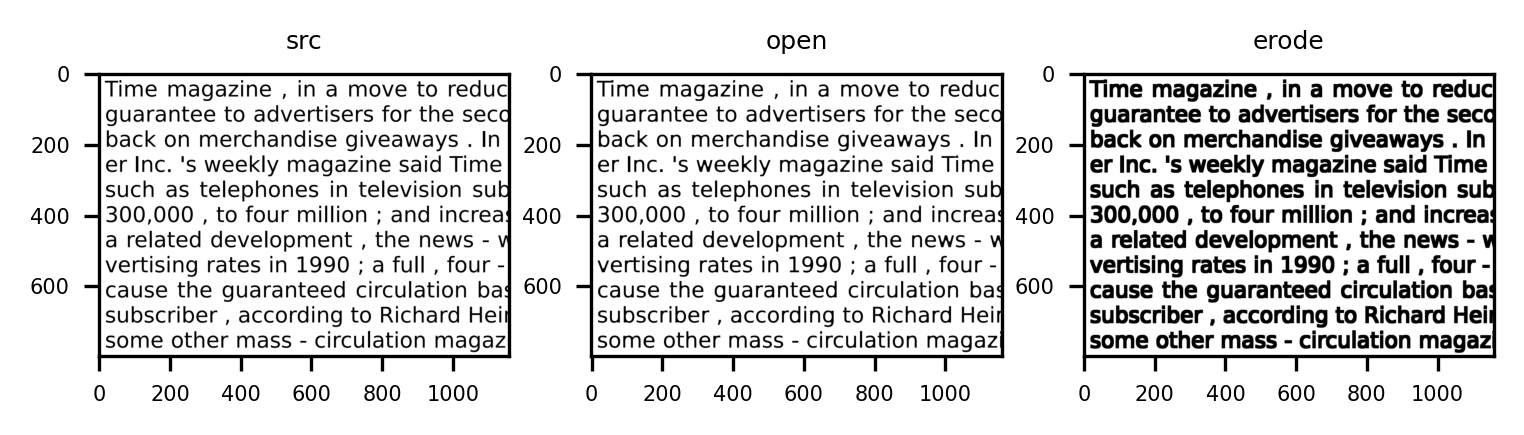

In [12]:
kernel = effect.create_2D_kernel((5,5), kernel_type="ones")
erode = effect.erode(src, kernel)
open = effect.open(src, kernel) # retains more of the foreground shape than erosion, given the same kernel

# display input and output image
fig = plt.figure(figsize=(6, 4), dpi=300)
fig.add_subplot(1,3,1)
plt.imshow(src, cmap="gray")
plt.title('src', fontsize=6)
fig.add_subplot(1,3,2)
plt.imshow(open, cmap="gray")
plt.title('open', fontsize=6)
fig.add_subplot(1,3,3)
plt.imshow(erode, cmap="gray")
plt.title('erode', fontsize=6)
plt.show()

## Kernel types:

To have a finer control of the morphological operation over the different shape of the text characters. We can adjust the size and shape of the structuring element, or kernel. A kernel determines the precise details of the effect of the operator on the image. It is usually a small 2D binary array of 1s and 0s.

Here are some of the supported kernel types:

1. **Ones**: kernel is filled with all 1s in shape (rows, cols)
        Ex:
        [[1,1,1],
         [1,1,1],
         [1,1,1]]
1. **upper_triangle**: upper triangular matrix filled with ones
        Ex:
        [[1,1,1],
         [0,1,1],
         [0,0,1]]
1. **lower_triangle**: lower triangular matrix filled with ones
        Ex:
        [[1,0,0],
         [1,1,0],
         [1,1,1]]
1. **X**: "X" shape cross
        Ex:
        [[1,0,1],
         [0,1,0],
         [1,0,1]]
1. **plus**: "+" shape cross
        Ex:
        [[0,1,0],
         [1,1,1],
         [0,1,0]]
1. **Ellipse**: ellipitcal kernel
        Ex:
        [[0, 0, 1, 0, 0],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [0, 0, 1, 0, 0]]
 
For more information on kernels, see [structuring element](http://homepages.inf.ed.ac.uk/rbf/HIPR2/strctel.htm).

Note that the shape of the kernel usually amplifies the effect on similar shapes in the foreground of the image. See the following cell for example.

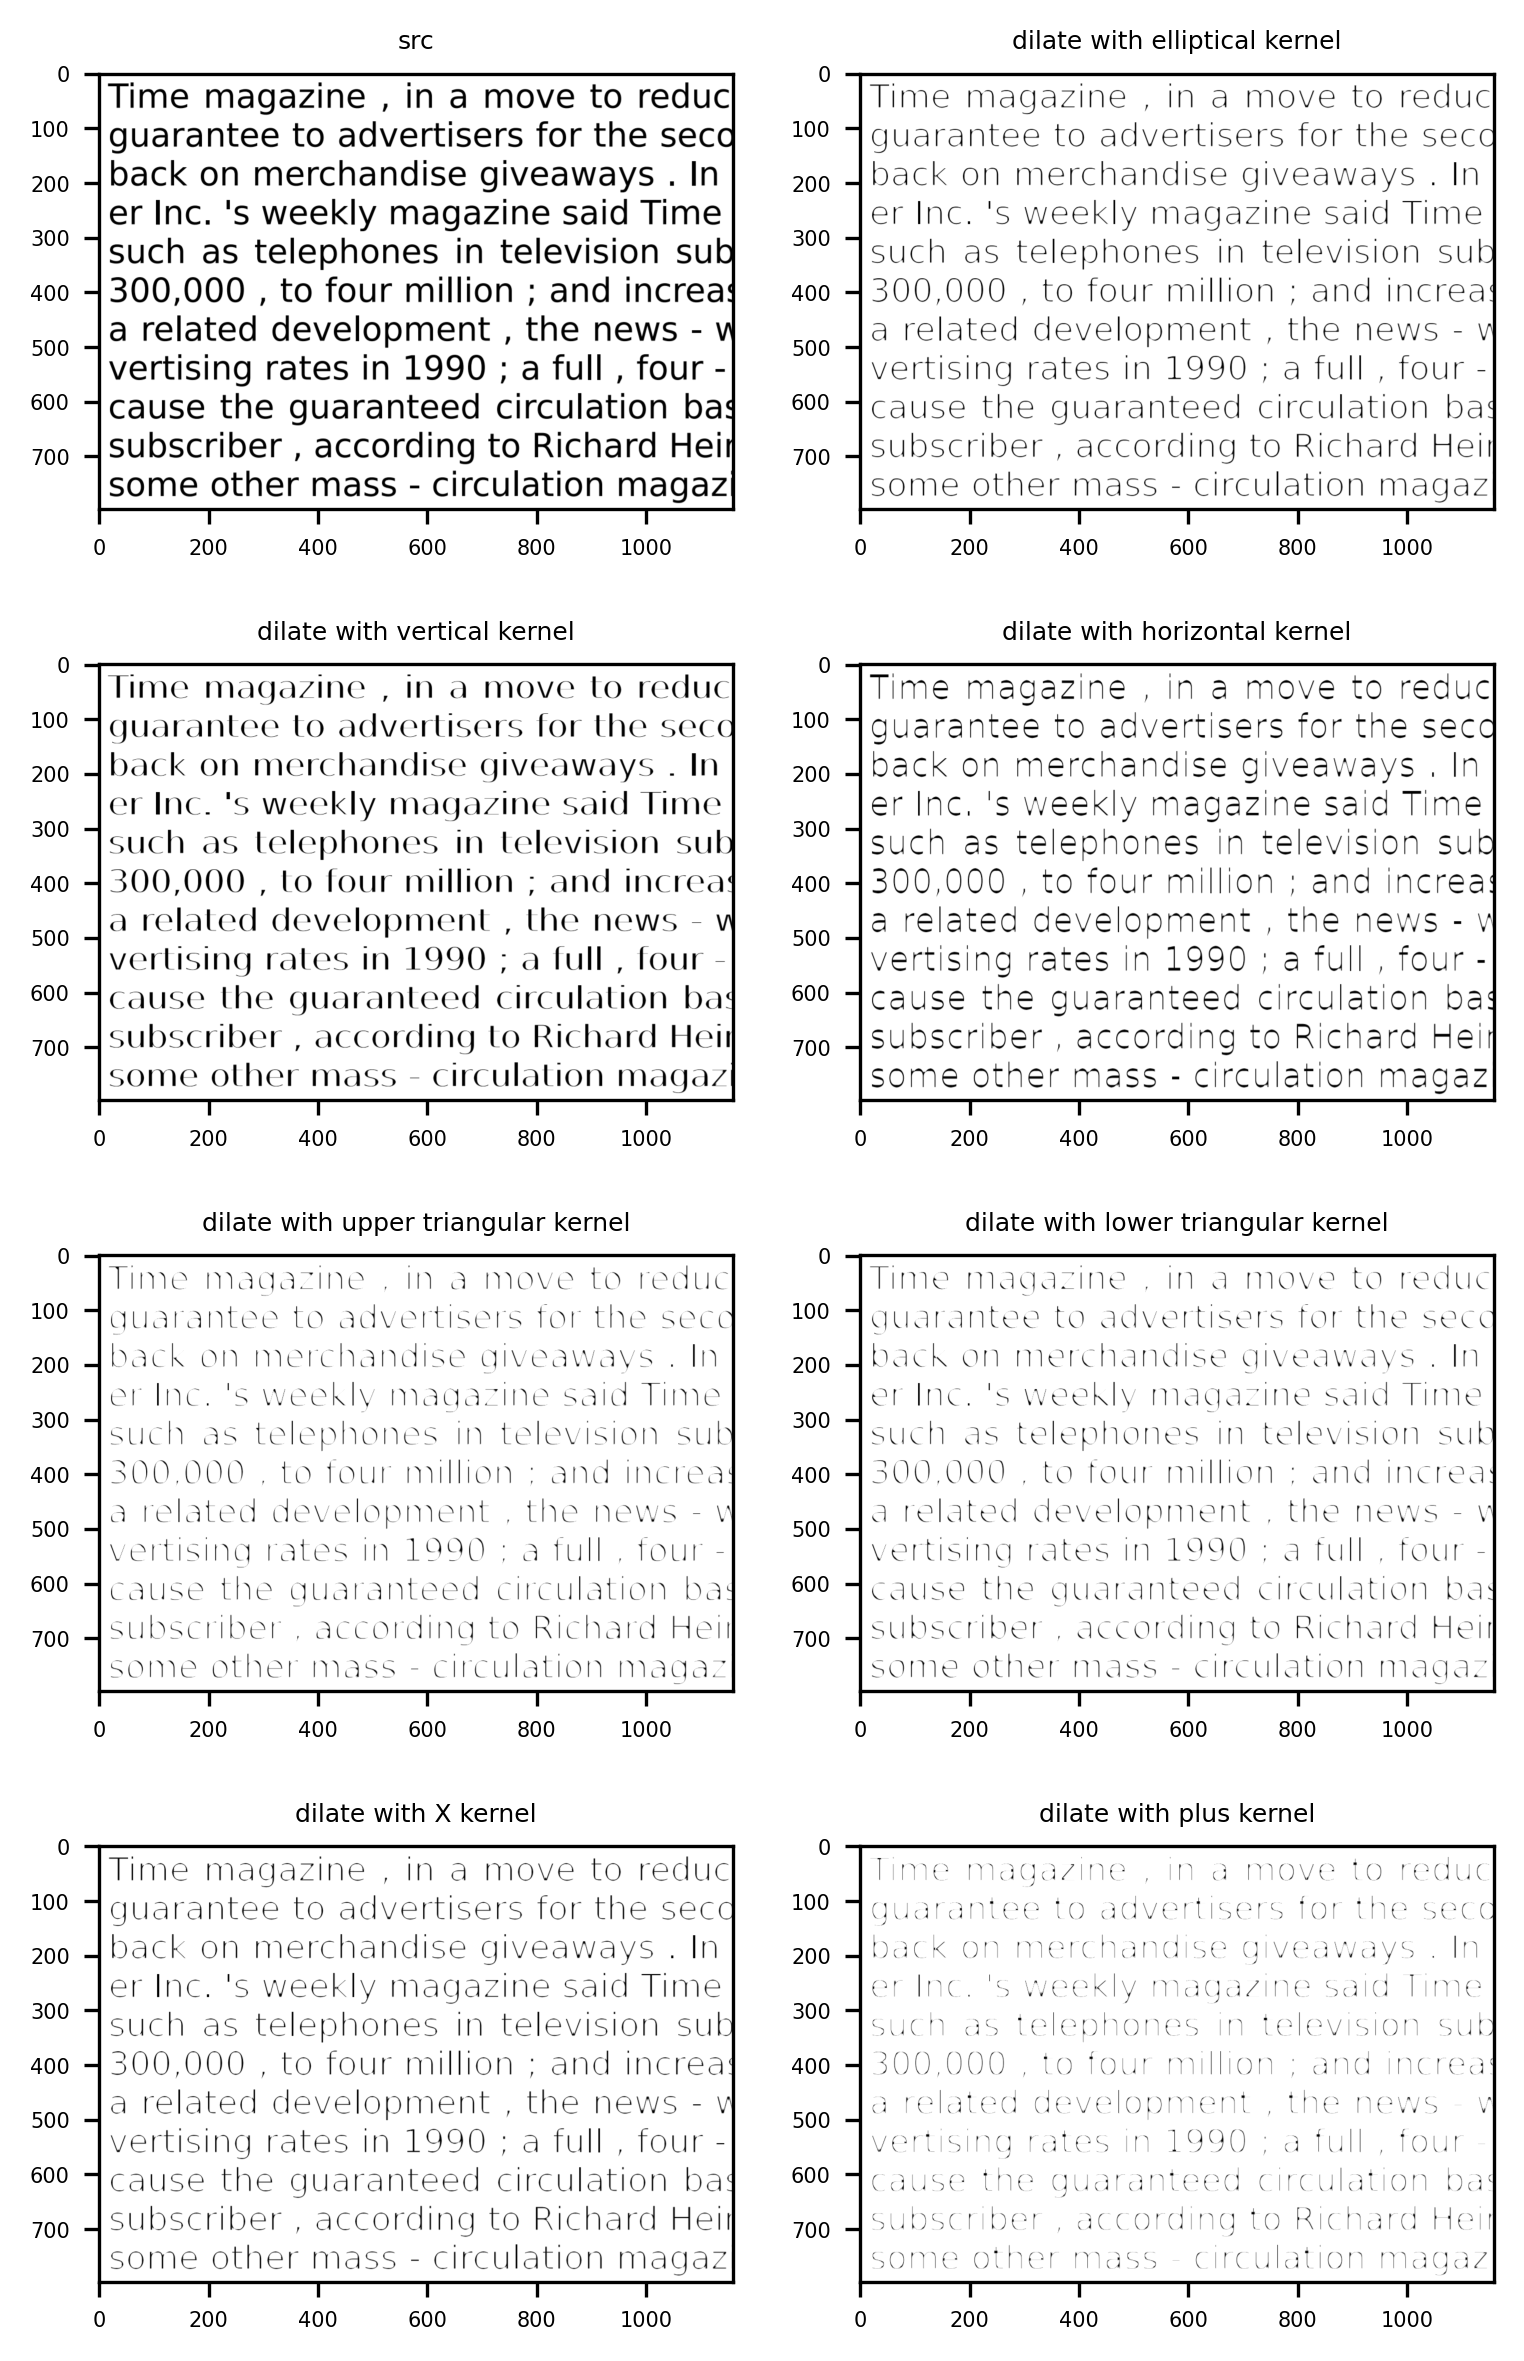

In [33]:
elliptical_kernel = effect.create_2D_kernel((4,4), kernel_type="ellipse")
vertical_kernel = effect.create_2D_kernel((5,1), kernel_type="ones")
horizontal_kernel = effect.create_2D_kernel((1,5), kernel_type="ones")
upper_tri_kernel = effect.create_2D_kernel((5,5), kernel_type="upper_triangle")
lower_tri_kernel = effect.create_2D_kernel((5,5), kernel_type="lower_triangle")
x_kernel = effect.create_2D_kernel((4,4), kernel_type="x")
plus_kernel = effect.create_2D_kernel((6,6), kernel_type="plus")

dilate_w_elliptical_k = effect.dilate(src, elliptical_kernel)
dilate_w_vertical_k = effect.dilate(src, vertical_kernel)
dilate_w_horizontal_k = effect.dilate(src, horizontal_kernel)
dilate_w_upper_tri_k = effect.dilate(src, upper_tri_kernel)
dilate_w_lower_tri_k = effect.dilate(src, lower_tri_kernel)
dilate_w_x_kernel = effect.dilate(src, x_kernel)
dilate_w_plus_kernel = effect.dilate(src, plus_kernel)

# display input and output image
fig = plt.figure(figsize=(6, 10), dpi=300)
fig.add_subplot(4,2,1)
plt.imshow(src, cmap="gray")
plt.title('src', fontsize=6)
fig.add_subplot(4,2,2)
plt.imshow(dilate_w_elliptical_k, cmap="gray")
plt.title('dilate with elliptical kernel', fontsize=6)
fig.add_subplot(4,2,3)
plt.imshow(dilate_w_vertical_k, cmap="gray")
plt.title('dilate with vertical kernel', fontsize=6)
fig.add_subplot(4,2,4)
plt.imshow(dilate_w_horizontal_k, cmap="gray")
plt.title('dilate with horizontal kernel', fontsize=6)
fig.add_subplot(4,2,5)
plt.imshow(dilate_w_upper_tri_k, cmap="gray")
plt.title('dilate with upper triangular kernel', fontsize=6)
fig.add_subplot(4,2,6)
plt.imshow(dilate_w_lower_tri_k, cmap="gray")
plt.title('dilate with lower triangular kernel', fontsize=6)
fig.add_subplot(4,2,7)
plt.imshow(dilate_w_x_kernel, cmap="gray")
plt.title('dilate with X kernel', fontsize=6)
fig.add_subplot(4,2,8)
plt.imshow(dilate_w_plus_kernel, cmap="gray")
plt.title('dilate with plus kernel', fontsize=6)
plt.show()